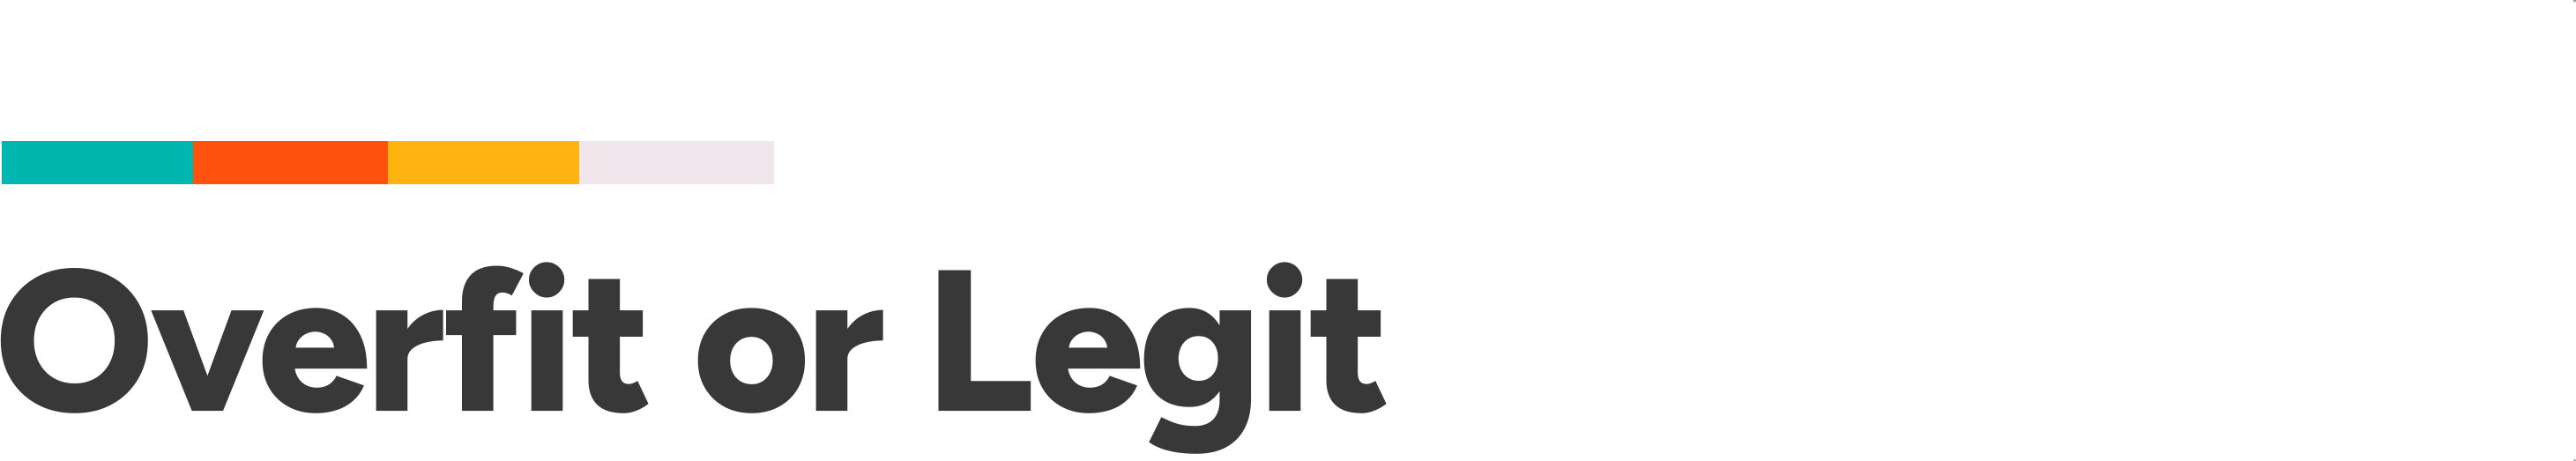

#
 
<div class="alert alert-info">

**IMPORTING LIBRARIES AND DATA**

</div>

In [2]:
import os
import glob
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from tsfracdiff import FractionalDifferentiator
from hmmlearn import hmm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, precision_score, f1_score, accuracy_score, 
    classification_report, confusion_matrix, roc_curve, auc, 
    precision_recall_curve, matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler
# from tpot import TPOTClassifier
import ta
import h2o
from h2o.automl import H2OAutoML

sns.set(style='dark', palette='viridis')

warnings.filterwarnings('ignore')

In [263]:
directory_path = 'forex_lite'
files = glob.glob(os.path.join(directory_path, '*.csv'))

content = []
for i in files:
    df = pd.read_csv(i, index_col = 'Date', header = 0)
    content.append(df)

prices = pd.concat(content, axis = 1)
prices.index = pd.to_datetime(prices.index, errors = 'coerce')
prices_hourly = prices.resample('1H').last().ffill()
prices_daily = prices.resample('1D').last().ffill()

In [272]:
prices_daily

,EURUSD,GBPUSD,USDJPY
Date,,,
2010-01-03,1.42705,1.60877,92.973
2010-01-04,1.44189,1.60758,92.270
2010-01-05,1.43675,1.59915,91.777
2010-01-06,1.44238,1.60237,92.274
2010-01-07,1.43117,1.59310,93.316
...,...,...,...
2024-05-03,1.07623,1.25454,152.847
2024-05-04,1.07623,1.25454,152.847
2024-05-05,1.07572,1.25396,153.637


In [250]:
prices_daily = prices.resample('D').last().ffill()

#
 
<div class="alert alert-info">

**FEATURE ENGINEERING**

</div>

In [5]:
def create_lag_price_features(price: pd.DataFrame, order: int = 14) -> pd.DataFrame:
    """Create lag features for close price"""
    lag_price = pd.DataFrame(index=price.index)
    for i in range(1, order + 1):
        lag_price[f'lag_{i}'] = price.shift(i)
    return lag_price

def regime_hmm(test_data: pd.Series, train_data: pd.Series, n_states: int = 2, n_iter: int = 1000) -> pd.DataFrame:
    """Apply Hidden Markov Model to detect regimes in the data and return the probabilities of each state"""
    test_data = test_data.to_frame()
    train_data = train_data.to_frame()
    
    hmm_model = hmm.GaussianHMM(n_iter=n_iter, n_components=n_states, covariance_type='full', init_params='stmc')
    hmm_model.fit(train_data)
    hmm_probs = hmm_model.predict_proba(test_data)
    
    hmm_results = pd.DataFrame(index=test_data.index)
    for state in range(n_states):
        hmm_results[f'hmm_state_{state}'] = hmm_probs[:, state]

    return hmm_results

def regime_gmm(data: pd.Series, n_states: int = 2) -> pd.DataFrame:
    """Apply Gaussian Mixture Model to detect regimes in the data and return the probabilities of each state"""
    gmm_model = GaussianMixture(n_components=n_states)
    gmm_model.fit(data.to_frame())
    gmm_probs = gmm_model.predict_proba(data.to_frame())

    gmm_results = pd.DataFrame(index=data.index)
    for state in range(n_states):
        gmm_results[f'gmm_state_{state}'] = gmm_probs[:, state]

    return gmm_results

def generate_features(close: pd.Series, lag_order: int = 14) -> pd.DataFrame:
    """Generate various technical indicators and features from closing prices"""
    returns = close.pct_change().shift(-lag_order)
    features = pd.DataFrame()
    features['close'] = close
    features['returns'] = returns
    
    features['sma_10'] = ta.trend.sma_indicator(close, window=10)
    features['sma_20'] = ta.trend.sma_indicator(close, window=20)
    features['sma_100'] = ta.trend.sma_indicator(close, window=100)
    features['ema_10'] = ta.trend.ema_indicator(close, window=10)
    features['ema_20'] = ta.trend.ema_indicator(close, window=20)
    features['ema_100'] = ta.trend.ema_indicator(close, window=100)
    features["roc_10"] = ta.momentum.roc(close, window=10, fillna=True)
    features["roc_20"] = ta.momentum.roc(close, window=20, fillna=True)
    features["roc_100"] = ta.momentum.roc(close, window=100, fillna=True)
    features['bb_upper'] = ta.volatility.bollinger_hband(close)
    features['bb_middle'] = ta.volatility.bollinger_mavg(close)
    features['bb_lower'] = ta.volatility.bollinger_lband(close)

    features['rsi_10'] = ta.momentum.rsi(close, window=10, fillna=True)
    features['rsi_20'] = ta.momentum.rsi(close, window=20, fillna=True)
    features['rsi_100'] = ta.momentum.rsi(close, window=100, fillna=True)
    macd_line = np.log(close.ewm(span=12).mean() / close.ewm(span=26).mean())
    signal_line = macd_line.ewm(span=9).mean()
    features["log_macd_hist"] = macd_line - signal_line
    features["log_dpo"] = np.log(close.rolling(11).mean() / close.rolling(20).mean())

    gmm_on_return = regime_gmm(features['returns'].dropna(), n_states=2)
    features = features.join(gmm_on_return, how='left')

    lag_price = create_lag_price_features(close, order=lag_order)
    features = features.join(lag_price)
    
    return features

https://github.com/letianzj/QuantResearch/blob/master/notebooks/gaussian_mixture_markov_switching.ipynb

https://letianzj.github.io/gaussian-mixture-markov-regime-switching.html

In [295]:
df = generate_features(prices_daily['EURUSD'])
df

,close,returns,sma_10,sma_20,sma_100,ema_10,ema_20,ema_100,roc_10,roc_20,...,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-03,1.42705,-0.003024,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1.44189,0.004225,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.43675,-0.013178,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.44238,-0.007845,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,1.43117,0.002234,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03,1.07623,NaN,1.071016,1.068108,1.079400,1.071204,1.070965,1.078222,0.570024,1.147535,...,1.07058,1.06929,1.06929,1.07256,1.06989,1.07013,1.06526,1.06563,1.06561,1.06561
2024-05-04,1.07623,NaN,1.071650,1.068695,1.079318,1.072118,1.071466,1.078182,0.592584,1.102876,...,1.07136,1.07058,1.06929,1.06929,1.07256,1.06989,1.07013,1.06526,1.06563,1.06561
2024-05-05,1.07572,NaN,1.071966,1.069363,1.079224,1.072773,1.071872,1.078133,0.294622,1.257577,...,1.06650,1.07136,1.07058,1.06929,1.06929,1.07256,1.06989,1.07013,1.06526,1.06563


In [296]:
df.isna().sum()

close             0
returns          14
sma_10            9
sma_20           19
sma_100          99
ema_10            9
ema_20           19
ema_100          99
roc_10            0
roc_20            0
roc_100           0
bb_upper         19
bb_middle        19
bb_lower         19
rsi_10            0
rsi_20            0
rsi_100           0
log_macd_hist     0
log_dpo          19
gmm_state_0      14
gmm_state_1      14
lag_1             1
lag_2             2
lag_3             3
lag_4             4
lag_5             5
lag_6             6
lag_7             7
lag_8             8
lag_9             9
lag_10           10
lag_11           11
lag_12           12
lag_13           13
lag_14           14
dtype: int64

#
 
<div class="alert alert-info">

**META LABELLING TRIPLE BARRIER LOPEZ**

</div>

<div class = "alert alert-example">  

- Fractionally differentiated log prices are computed to adjust for long-term dependencies in the price series.
- Daily volatility with log returns is calculated to capture the level of price fluctuation.
- **Primary model**: CUSUM filter events are detected to identify potential trading opportunities based on significant price movements.
- **Secondary model**: Triple barrier events are generated to define the boundaries for taking profit or stopping losses in trading strategies.
- Labels are assigned to indicate whether a particular trade resulted in a profit, loss, or no action.

</div>

### Fractional differenced log price

For the ADF test we're aggregating the data to a lower frequency, i.e. to daily data to speed things up cos, when testing properties such as presence of a unit root, what matters is the time span, not the frequency at which the data is sampled (unless the sample is too small for asymptotic inference, that is.)

In [275]:
def get_fracdiff_log_price(
    close: pd.Series,
) -> pd.Series:
    """ create fractional differenced log price series """
    log_prices = np.log(close)
    adf_result = adfuller(log_prices.resample('D').last().ffill())
    fracDiff = FractionalDifferentiator()
    if adf_result[1] > 0.05: 
        frac_diff_log_price = fracDiff.FitTransform(log_prices)
    else: 
        frac_diff_log_price = log_prices
    return frac_diff_log_price

In [276]:
df['frac_diff_log'] = get_fracdiff_log_price(df['close'])
df.tail(1)

,close,returns,sma_10,sma_20,sma_100,ema_10,ema_20,ema_100,roc_10,roc_20,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,frac_diff_log,volat
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-07,1.07648,NaN,1.073418,1.07058,1.079063,1.074019,1.07272,1.078071,0.672409,0.909278,...,1.0665,1.07136,1.07058,1.06929,1.06929,1.07256,1.06989,1.07013,0.017176,0.004088


### Daily volatility using EWMA

In [11]:
def get_daily_volat_w_log_returns(
    close: pd.Series,
    span: int = 100
) -> pd.Series:
    """ create daily volatility series using ewm """

    df = close.index.searchsorted(close.index - pd.Timedelta(days=1))        
    df = df[df > 0]
    df = pd.Series(close.index[df - 1], index = close.index[close.shape[0] - df.shape[0]:])
    returns = np.log(close.loc[df.index] / close.loc[df.values].values)
    stds = returns.ewm(span=span).std().rename("std")

    return stds

In [277]:
df['volat'] = get_daily_volat_w_log_returns(df['close'], 100)
df.tail(1)

,close,returns,sma_10,sma_20,sma_100,ema_10,ema_20,ema_100,roc_10,roc_20,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,frac_diff_log,volat
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-07,1.07648,NaN,1.073418,1.07058,1.079063,1.074019,1.07272,1.078071,0.672409,0.909278,...,1.0665,1.07136,1.07058,1.06929,1.06929,1.07256,1.06989,1.07013,0.017176,0.004088


### Main model: Momentum strat using EWA

In [278]:
# def get_position(
#     prices: pd.Series,
#     fast_window: int,
#     slow_window: int,
#     mean_reversion: bool = False,
# ) -> pd.Series:
#     """ create position series based on moving averages """
#     if fast_window >= slow_window:
#         raise ValueError("The fast window should be smaller than the slow window.")

#     fast_moving_average = prices.ewm(span=fast_window, adjust=False, min_periods=1).mean()
#     slow_moving_average = prices.ewm(span=slow_window, adjust=False, min_periods=1).mean()

#     if mean_reversion:
#         return (fast_moving_average < slow_moving_average).astype(int) * 2 - 1
#     else:
#         return (fast_moving_average >= slow_moving_average).astype(int) * 2 - 1

In [297]:
def get_position(
    prices: pd.Series,
) -> pd.Series:
    pos = []
    for i in range(len(prices)):
        if prices.iloc[i] < prices.iloc[i-1]:
            pos.append(1)
        elif prices.iloc[i] > prices.iloc[i-1]:
            pos.append(-1)
        else:
            pos.append(0)
    return pos

In [298]:
df['position'] = get_position(prices_daily['EURUSD'])
df.position.value_counts()

position
 1    2253
-1    2211
 0     775
Name: count, dtype: int64

In [294]:
def vertical_barrier(
    close: pd.Series,
    time_events: pd.DatetimeIndex,
    number_days: int) -> pd.Series:
    """ create vertical barrier series: the exit timestamp after a certain number of days """
    timestamp_array = close.index.searchsorted(time_events + pd.Timedelta(days=number_days))
    timestamp_array = timestamp_array[timestamp_array < close.shape[0]]
    timestamp_array = pd.Series(close.index[timestamp_array], index=time_events[:timestamp_array.shape[0]])
    return timestamp_array 

def main_labelling(
    df: pd.DataFrame,
    num_days: int # holding days / vertical barriers
) -> pd.DataFrame:
    end_times = vertical_barrier(df['close'], df.index, num_days).dropna()
    df['vert_bars'] = end_times.reindex(df.index)
    df['end_time'] = df['vert_bars']
    
    df['end_close'] = df['vert_bars'].map(df['close'])

    df['profit'] = df['end_close'] / df['close'] - 1
    df['profit'] *= df['position']
    df['outcome'] = np.sign(df['profit'])
    df.loc[df['profit'] <= 0, 'outcome'] = 0
    df['outcome'].reindex(df.index)
    return df

In [290]:
df = main_labelling(df, 100)
df.iloc[:, -7:]

,position,pnl,vert_bars,end_time,end_close,profit,outcome
Date,,,,,,,
2010-01-03,-1,NaN,2010-04-13,2010-04-13,1.36414,0.044084,1.0
2010-01-04,-1,-0.004225,2010-04-14,2010-04-14,1.36511,0.053250,1.0
2010-01-05,1,0.013178,2010-04-15,2010-04-15,1.35388,-0.057679,0.0
2010-01-06,-1,-0.007845,2010-04-16,2010-04-16,1.35017,0.063929,1.0
2010-01-07,1,-0.002234,2010-04-17,2010-04-17,1.35017,-0.056597,0.0
...,...,...,...,...,...,...,...
2024-05-03,-1,NaN,NaT,NaT,NaN,NaN,NaN
2024-05-04,0,NaN,NaT,NaT,NaN,NaN,NaN
2024-05-05,1,NaN,NaT,NaT,NaN,NaN,NaN


We define `outcome` as the direction of return (1 for gain, 0 for neutral or loss)

In [292]:
df.isna().sum()

close              0
returns           14
sma_10             9
sma_20            19
sma_100           99
ema_10             9
ema_20            19
ema_100           99
roc_10             0
roc_20             0
roc_100            0
bb_upper          19
bb_middle         19
bb_lower          19
rsi_10             0
rsi_20             0
rsi_100            0
log_macd_hist      0
log_dpo           19
gmm_state_0       14
gmm_state_1       14
lag_1              1
lag_2              2
lag_3              3
lag_4              4
lag_5              5
lag_6              6
lag_7              7
lag_8              8
lag_9              9
lag_10            10
lag_11            11
lag_12            12
lag_13            13
lag_14            14
frac_diff_log    486
volat              3
position           0
pnl               15
vert_bars        100
end_time         100
end_close        100
profit           100
outcome          100
dtype: int64

In [293]:
df.outcome.value_counts()

outcome
0.0    2917
1.0    2222
Name: count, dtype: int64

### Meta model: Triple barrier

**Position (side)**: In layman's term, all positions are held for like 100 units of time (aka until it hits vertical barrier). But for events that are considered significant (according to CUMSUM filter), it's held until we hit profit taking or stop loss, or until it expires at the vertical barrier.

**Outcome (labels)**: Profitable = assigned 1, neutral / loss = assigned 0.

**CUMSUM: identify significant events to apply a secondary meta labelling level on top of main model**

In [199]:
def cusum_filter_events_dynamic_threshold(
    prices: pd.Series,
    threshold: pd.Series,
) -> pd.DatetimeIndex:
    """ identify events that are 'too' volatile based on 
    dynamic threshold using cumsum filter """
    events, shift_positive, shift_negative = [], 0, 0
    price_delta = prices.diff().dropna()
    thresholds = threshold.copy()
    price_delta, thresholds = price_delta.align(thresholds, join="inner", copy=False)

    for (index, value), threshold_ in zip(price_delta.to_dict().items(), thresholds.to_dict().values()):
        shift_positive = max(0, shift_positive + value)
        shift_negative = min(0, shift_negative + value)

        if shift_negative < -threshold_:
            shift_negative = 0
            events.append(index)

        elif shift_positive > threshold_:
            shift_positive = 0
            events.append(index)

    return pd.DatetimeIndex(events)

**TRIPLE BARRIERS: for the identified events, update the new exit time - instead of vertical barriers its whatever barrier hit first**

In [200]:
def triple_barrier_events(
    df: pd.DataFrame,
    ptsl: list[float], 
    filter_threshold: float
) -> pd.DataFrame:
    
    # significent events
    sig_events = cusum_filter_events_dynamic_threshold(np.log(df['close']), filter_threshold * df['volat'])
    sig_df = df.loc[sig_events, ['volat', 'position', 'close', 'vert_bars']]

    # ptsl
    profit_loss = ptsl[:2] 
    if ptsl[0] > 0:
        pt = ptsl[0] * sig_df['volat']
    else:
        pt = pd.Series(index = sig_df.index)
    if ptsl[1] > 0:
        sl = -ptsl[1] * sig_df['volat']
    else: 
        sl = pd.Series(index = sig_df.index)

    # return time barriers hit
    for start, end in sig_df['vert_bars'].items():
        price_segment = df['close'][start:end]
        # find log return of price slice
        returns = np.log(price_segment / price_segment.iloc[0]) * sig_df.at[start, 'position']
        # find the first index where the returns are below the stop-loss level sl[start]
        sig_df.loc[start, 'stop_loss'] = returns[returns < sl[start]].index.min()
        sig_df.loc[start, 'profit_taking'] = returns[returns > pt[start]].index.min()
        
    sig_df.dropna()
    sig_df['end_time'] = sig_df[['stop_loss', 'profit_taking', 'vert_bars']].min(axis=1)
    sig_df.dropna(subset=['end_time'], inplace=True)
    return sig_df

In [211]:
sig_df = meta_events(df, ptsl = [1.5, 1], filter_threshold = 1.5)
sig_df

,volat,position,close,vert_bars,stop_loss,profit_taking,end_time
2010-01-04 23:00:00,0.001350,-1,1.44189,2010-04-14 23:00:00,2010-01-05 03:00:00,2010-01-05 16:00:00,2010-01-05 03:00:00
2010-01-05 03:00:00,0.001611,-1,1.44635,2010-04-15 03:00:00,2010-01-11 00:00:00,2010-01-05 06:00:00,2010-01-05 06:00:00
2010-01-05 06:00:00,0.001744,-1,1.44162,2010-04-15 06:00:00,2010-01-10 21:00:00,2010-01-05 16:00:00,2010-01-05 16:00:00
2010-01-07 09:00:00,0.004749,-1,1.43346,2010-04-17 09:00:00,2010-01-08 11:00:00,2010-01-19 23:00:00,2010-01-08 11:00:00
2010-01-08 11:00:00,0.004635,-1,1.44039,2010-04-18 11:00:00,2010-01-10 22:00:00,2010-01-19 09:00:00,2010-01-10 22:00:00
...,...,...,...,...,...,...,...
2024-04-30 14:00:00,0.001819,1,1.06899,NaT,2024-04-30 20:00:00,2024-05-01 18:00:00,2024-04-30 20:00:00
2024-05-01 18:00:00,0.002757,1,1.07270,NaT,2024-05-01 19:00:00,2024-05-03 12:00:00,2024-05-01 19:00:00
2024-05-03 08:00:00,0.003026,1,1.07414,NaT,NaT,2024-05-03 12:00:00,2024-05-03 12:00:00
2024-05-03 12:00:00,0.003154,1,1.07926,NaT,2024-05-05 23:00:00,NaT,2024-05-05 23:00:00


In [218]:
sig_df.isna().sum()

volat              0
position           0
close              0
vert_bars         80
stop_loss        365
profit_taking    468
end_time           1
dtype: int64

**META LABELLING: find the new close/profit etc. & overlay the meta results on top of the main results**

In [233]:
testy = df.copy(deep = True)
testy.loc[sig_df.index, 'end_time'] = sig_df['end_time']
testy
testy['end_close'] = testy['vert_bars'].map(testy['close'])

testy['profit'] = testy['end_close'] / testy['close'] - 1
testy['profit'] *= testy['position']
testy['outcome'] = np.sign(testy['profit'])
testy.loc[testy['profit'] <= 0, 'outcome'] = 0
testy['outcome'].reindex(testy.index)
testy.dropna(inplace = True)

In [235]:
testy.outcome.value_counts()

outcome
0.0    61976
1.0    60919
Name: count, dtype: int64

In [236]:
df.outcome.value_counts()

outcome
0.0    61995
1.0    61308
Name: count, dtype: int64

In [ ]:
def meta_labelling(
    df: pd.DataFrame,
    ptsl: list[float], 
    filter_threshold: float    
) -> pd.DataFrame:
    
    sig_df = triple_barrier_events(df, ptsl, filter_threshold)
    df.join(sig_df, how='left')

    sig_df.dropna(subset=['end_time'])
    sig_df['profit'] = 

    meta_labels = pd.Series(index = df.index)
    for idx, (start, end) in triple_barrier_events['end_time'].iteritems():
        meta_labels.loc[start:end] = triple_barrier_events.loc[idx, 'outcome']
    return meta_labels

In [29]:
def cusum_filter_events_dynamic_threshold(
    prices: pd.Series,
    threshold: pd.Series
) -> pd.DatetimeIndex:
    """ identify events that are 'too' volatile based on 
    dynamic threshold using cumsum filter """
    time_events, shift_positive, shift_negative = [], 0, 0
    price_delta = prices.diff().dropna()
    thresholds = threshold.copy()
    price_delta, thresholds = price_delta.align(thresholds, join="inner", copy=False)

    for (index, value), threshold_ in zip(price_delta.to_dict().items(), thresholds.to_dict().values()):
        shift_positive = max(0, shift_positive + value)
        shift_negative = min(0, shift_negative + value)

        if shift_negative < -threshold_:
            shift_negative = 0
            time_events.append(index)

        elif shift_positive > threshold_:
            shift_positive = 0
            time_events.append(index)

    return pd.DatetimeIndex(time_events)

def triple_barrier(
    close: pd.Series,
    events: pd.DataFrame,
    profit_taking_stop_loss: list[float, float],
    molecule: list
) -> pd.DataFrame:
    """ identify triple barriers: pt, sl, vertical barrier """
    events_filtered = events.loc[molecule]
    output = events_filtered[['End Time']].copy(deep=True)

    if profit_taking_stop_loss[0] > 0:
        profit_taking = profit_taking_stop_loss[0] * events_filtered['Base Width']
    else:
        profit_taking = pd.Series(index=events.index)

    if profit_taking_stop_loss[1] > 0:
        stop_loss = -profit_taking_stop_loss[1] * events_filtered['Base Width']
    else:
        stop_loss = pd.Series(index=events.index)

    for location, timestamp in events_filtered['End Time'].fillna(close.index[-1]).items():
        df = close[location:timestamp]
        df = np.log(df / close[location]) * events_filtered.at[location, 'position']
        output.loc[location, 'stop_loss'] = df[df < stop_loss[location]].index.min()
        output.loc[location, 'profit_taking'] = df[df > profit_taking[location]].index.min()
    return output

def meta_events(
    close: pd.Series,
    time_events: pd.DatetimeIndex,
    ptsl: list, 
    target: pd.Series,
    return_min: float,
    num_threads: int,
    timestamp: pd.Series = False,
    side: pd.Series = None
) -> pd.DataFrame:
    """ apply the triple barriers to the identified volatile events
    (exit price recorded at whatever barrier it hits first out of the 3) """
    target = target.loc[time_events]
    target = target[target > return_min]
    if timestamp is False:
        timestamp = pd.Series(pd.NaT, index=time_events)

    if side is None:
        side_position, profit_loss = pd.Series(1., index=target.index), [ptsl[0], ptsl[0]]
    else:
        side_position, profit_loss = side.loc[target.index], ptsl[:2]

    events = pd.concat({'End Time': timestamp, 'Base Width': target, 'position': side_position}, axis=1).dropna(subset=['Base Width'])
    if num_threads > 1:
        with ProcessPoolExecutor(num_threads) as executor:
            df0 = list(executor.map(triple_barrier, [close] * num_threads, [events] * num_threads, [profit_loss] * num_threads, list(np.array_split(time_events, num_threads))))
    else:
        df0 = list(map(triple_barrier, [close] * num_threads, [events] * num_threads, [profit_loss] * num_threads, list(np.array_split(time_events, num_threads))))
    df0 = pd.concat(df0, axis=0)
    events['End Time'] = df0.dropna(how='all').min(axis=1)

    if side is None:
        events = events.drop('position', axis=1)
    return events

def meta_labeling(events: pd.DataFrame, close: pd.Series) -> pd.DataFrame:
    """ create labels given triple barriers
    (instead of constant time horizon like in normal labelling) """
    events_filtered = events.dropna(subset=['End Time'])
    all_dates = events_filtered.index.union(events_filtered['End Time'].values).drop_duplicates()
    close_filtered = close.reindex(all_dates, method='bfill')
    out = pd.DataFrame(index = events_filtered.index)
    out['End Time'] = events['End Time']
    out['profit'] = close_filtered.loc[events_filtered['End Time'].values].values / close_filtered.loc[events_filtered.index] - 1
    if 'position' in events_filtered:
        out['profit'] *= events_filtered['position']
    out['outcome'] = np.sign(out['profit'])
    if 'position' in events_filtered:
        out.loc[out['profit'] <= 0, 'outcome'] = 0
        out['position'] = events_filtered['position']
    return out

Side = position (long = 1, short = -1)

Label = direction of return (profitable (+1), unprofitable or neutral (0))

In [31]:
df['outcome_w_metalabels'] = df['outcome'].copy()
df['outcome_w_metalabels'].update(secondary['outcome'])
df.dropna(inplace = True)
df.outcome_w_metalabels.value_counts()

outcome_w_metalabels
1.0    61721
0.0    61174
Name: count, dtype: int64

#
 
<div class="alert alert-success">

**Inquiry question: DOES META LABELLING ACTUALLY INCREASE SIGNAL EFFICACY?**

</div>

It went from: 36564 ones to 37515 ones (IS)

To evaluate the effcacy of meta-labeling we look at a models performance metrics between the validation set and the out-of-sample test set. 

-> RandomForestClassifier

This allows us to draw conclusions about the models ability to generalize. In particular we need to look at the recall, precision, F1 score, and accuracy. The reason why we dont compare the strategies performance metrics (annualized returns, sharpe ratio, and drawdowns) is because the two data sets are from very di erent time periods. For example, if the validation set has a much higher volatility than the test set, then the validation returns will be larger. This will prevent like for like comparison. We can however compare strategy metrics if they are both from the same time period. We do provide performance metrics on the test data. Additionally we add a performance tear sheet, and see that meta-labeling results in better strategy metrics but it should be noted that we have yet to add a bet sizing component to the strategy. Additionally the two strategies we test are based on technical analysis and they dont provide the best signals. A primary model with better predictive power would provide further insigh

In [32]:
df['outcome_w_metalabels'].value_counts()

outcome_w_metalabels
1.0    61721
0.0    61174
Name: count, dtype: int64

In [33]:
df['outcome'].value_counts()

outcome
0.0    61976
1.0    60919
Name: count, dtype: int64

In [34]:
"""
features = df.drop(columns=['position', 'outcome', 'outcome_w_metalabels'])
target_outcome = df['outcome']
target_meta_outcome = df['outcome_w_metalabels']

X_train, X_test, y_train, y_test = train_test_split(features, target_outcome, test_size=0.2, random_state=42)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(features, target_meta_outcome, test_size=0.2, random_state=42)

primary_model = RandomForestClassifier(random_state=42)
primary_model.fit(X_train, y_train)
primary_predictions = primary_model.predict(X_test)

X_train_meta['primary_predictions'] = primary_model.predict(X_train)
X_test_meta['primary_predictions'] = primary_predictions

meta_model = RandomForestClassifier(random_state=42)
meta_model.fit(X_train_meta, y_train_meta)
meta_predictions = meta_model.predict(X_test_meta)

primary_accuracy = accuracy_score(y_test, primary_predictions)
primary_mcc = matthews_corrcoef(y_test, primary_predictions)
primary_report = classification_report(y_test, primary_predictions)
primary_conf_matrix = confusion_matrix(y_test, primary_predictions)
primary_fpr, primary_tpr, _ = roc_curve(y_test, primary_predictions)
primary_roc_auc = auc(primary_fpr, primary_tpr)
primary_precision, primary_recall, _ = precision_recall_curve(y_test, primary_predictions)
primary_pr_auc = auc(primary_recall, primary_precision)

meta_accuracy = accuracy_score(y_test_meta, meta_predictions)
meta_mcc = matthews_corrcoef(y_test_meta, meta_predictions)
meta_report = classification_report(y_test_meta, meta_predictions)
meta_conf_matrix = confusion_matrix(y_test_meta, meta_predictions)
meta_fpr, meta_tpr, _ = roc_curve(y_test_meta, meta_predictions)
meta_roc_auc = auc(meta_fpr, meta_tpr)
meta_precision, meta_recall, _ = precision_recall_curve(y_test_meta, meta_predictions)
meta_pr_auc = auc(meta_recall, meta_precision)

print("Primary model:")
print(f"Accuracy: {primary_accuracy}")
print(f"MCC: {primary_mcc}")
print(f"ROC AUC: {primary_roc_auc}")
print(f"Precision-recall AUC: {primary_pr_auc}")
print(primary_report)
print(primary_conf_matrix)

print("\nMeta model:")
print(f"Accuracy: {meta_accuracy}")
print(f"MCC: {meta_mcc}")
print(f"ROC AUC: {meta_roc_auc}")
print(f"Precision-recall AUC: {meta_pr_auc}")
print(meta_report)
print(meta_conf_matrix)
"""

'\nfeatures = df.drop(columns=[\'position\', \'outcome\', \'outcome_w_metalabels\'])\ntarget_outcome = df[\'outcome\']\ntarget_meta_outcome = df[\'outcome_w_metalabels\']\n\nX_train, X_test, y_train, y_test = train_test_split(features, target_outcome, test_size=0.2, random_state=42)\nX_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(features, target_meta_outcome, test_size=0.2, random_state=42)\n\nprimary_model = RandomForestClassifier(random_state=42)\nprimary_model.fit(X_train, y_train)\nprimary_predictions = primary_model.predict(X_test)\n\nX_train_meta[\'primary_predictions\'] = primary_model.predict(X_train)\nX_test_meta[\'primary_predictions\'] = primary_predictions\n\nmeta_model = RandomForestClassifier(random_state=42)\nmeta_model.fit(X_train_meta, y_train_meta)\nmeta_predictions = meta_model.predict(X_test_meta)\n\nprimary_accuracy = accuracy_score(y_test, primary_predictions)\nprimary_mcc = matthews_corrcoef(y_test, primary_predictions)\nprimary_report =

primary model performs slightly better across most metrics.

#
 
<div class="alert alert-info">

**MODEL FITTING**

</div>

In [35]:
features = df.drop(columns=['position', 'outcome', 'outcome_w_metalabels'])
target_meta = df['outcome_w_metalabels']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(features_scaled, target_meta, test_size=0.2, random_state=404)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [ ]:
def sharpe_ratio(returns: np.ndarray, risk_free_rate: float = 0.0) -> float:
    excess_returns = returns - risk_free_rate
    std = np.std(excess_returns)
    if std != 0:
        return ((excess_returns.mean() / std) * np.sqrt(252*24))  # to annualise
    else:
        return 0

def max_drawdown(returns: np.ndarray) -> float:
    cumulative_returns = np.cumprod(1 + returns) - 1
    drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
    return np.min(drawdowns)

will delete later: split data by half for a quick trial run

In [ ]:
dfcut = df.iloc[int(len(df)/2):, :]
features = dfcut.drop(columns=['position', 'outcome', 'outcome_w_metalabels'])
target_meta = dfcut['outcome_w_metalabels']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### H2O

In [ ]:
h2o.init(max_mem_size = "2G")

combined_df = pd.DataFrame(features_scaled, columns=features.columns)
combined_df['outcome_w_metalabels'] = target_meta.values
h2o_df = h2o.H2OFrame(combined_df)
train, test = h2o_df.split_frame(ratios=[.8], seed=1234)
x = train.columns[:-1]
y = 'outcome_w_metalabels'
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
print(f'Train/test length: {len(train), len(test)}')

aml = H2OAutoML(max_models=2, seed=404)
aml.train(x=x, y=y, training_frame=train)

lb = h2o.automl.get_leaderboard(aml, extra_columns="ALL")
lb_df = lb.as_data_frame()

all_preds = {}
for model_id in lb_df['model_id']:
    model = h2o.get_model(model_id)
    preds = model.predict(test)
    all_preds[model_id] = preds.as_data_frame()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from C:\Users\Kalulu\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Kalulu\AppData\Local\Temp\tmpkzez5bna
  JVM stdout: C:\Users\Kalulu\AppData\Local\Temp\tmpkzez5bna\h2o_Kalulu_started_from_python.out
  JVM stderr: C:\Users\Kalulu\AppData\Local\Temp\tmpkzez5bna\h2o_Kalulu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Bangkok
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_Kalulu_1w5x3p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.764 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Train/test length: (40470, 10071)
AutoML progress: |
13:47:08.644: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


h20 xgboost is not available on window 

In [ ]:
lb_df

NameError: name 'lb_df' is not defined

In [ ]:
gbm_results = all_preds['GBM_1_AutoML_1_20240803_134708']
gbm_results['predict'].value_counts() 

predict
1    5368
0    4703
Name: count, dtype: int64

In [ ]:
test

close,returns,sma_10,sma_20,sma_100,ema_10,ema_20,ema_100,z-score,roc_10,roc_20,roc_100,bb_upper,bb_middle,bb_lower,rsi_10,rsi_20,rsi_100,log_macd_hist,log_dpo,gmm_state_0,gmm_state_1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,frac_diff_log,volat,outcome_w_metalabels
-0.90511,-1.42706,-0.92388,-0.92828,-0.946386,-0.918814,-0.924206,-0.950972,-1.00526,0.251333,0.521431,0.646326,-0.937658,-0.92828,-0.917702,0.493196,0.382857,0.688054,0.535873,0.255412,-0.0528361,0.0528361,-0.90979,-0.914642,-0.90561,-0.924521,-0.950547,-0.930581,-0.921709,-0.924996,-0.94912,-0.918055,-0.916309,-0.905016,-0.903132,-0.909413,-0.687138,-0.355501,1
-0.899383,0.251357,-0.900809,-0.91293,-0.940176,-0.903259,-0.911606,-0.944899,0.424744,0.488242,0.141591,0.686693,-0.92895,-0.91293,-0.895781,0.431009,0.401293,0.711118,0.385304,0.528465,-0.110511,0.110511,-0.89712,-0.897286,-0.896758,-0.893628,-0.886853,-0.905068,-0.909734,-0.914583,-0.905558,-0.924477,-0.950499,-0.930527,-0.921702,-0.925032,-0.72257,-0.4165,1
-0.959781,-0.0427553,-0.9198,-0.918929,-0.937366,-0.930505,-0.924654,-0.944893,0.256032,-1.42039,-0.155401,0.261012,-0.92608,-0.918929,-0.910576,-0.967177,-0.61703,0.194902,-1.27079,0.103568,-0.112111,0.112111,-0.959254,-0.927311,-0.942404,-0.923132,-0.899349,-0.897085,-0.897238,-0.896707,-0.893583,-0.886816,-0.905028,-0.909701,-0.914587,-0.905594,-0.987445,-0.456314,1
-1.00126,-0.579148,-0.94308,-0.926083,-0.936615,-0.951868,-0.937983,-0.946709,-0.221606,-2.02588,-1.01881,-0.0313368,-0.914623,-0.926083,-0.936192,-1.31482,-1.04508,-0.128911,-1.80872,-0.707903,-0.104202,0.104202,-0.977651,-0.941543,-0.959759,-0.959232,-0.927291,-0.942383,-0.923098,-0.89931,-0.897054,-0.897229,-0.896698,-0.893561,-0.886819,-0.905074,-1.20229,-0.349466,1
-1.02105,-0.0954012,-0.955475,-0.929608,-0.936841,-0.964505,-0.945951,-0.948226,0.19508,-2.41435,-1.0174,-0.170784,-0.905901,-0.929608,-0.951867,-1.51913,-1.24964,-0.273968,-2.18837,-1.12765,-0.111963,0.111963,-1.00125,-0.977643,-0.941536,-0.959753,-0.959225,-0.927283,-0.942362,-0.923087,-0.89931,-0.897055,-0.897218,-0.896685,-0.893587,-0.88685,-1.26802,-0.268272,1
-1.04587,-0.253263,-0.970126,-0.935677,-0.937316,-0.979358,-0.955525,-0.950207,0.00397166,-2.85387,-1.74703,-0.345704,-0.896137,-0.935677,-0.973643,-1.73339,-1.48005,-0.450759,-2.59914,-1.53324,-0.110727,0.110727,-1.02104,-1.00125,-0.977636,-0.941529,-0.959746,-0.959218,-0.927263,-0.942352,-0.923087,-0.899311,-0.897045,-0.897206,-0.896711,-0.893619,-1.36977,-0.205165,1
-1.04934,-0.758567,-0.982747,-0.942865,-0.937826,-0.992141,-0.964519,-0.952217,-0.388361,-2.4617,-2.06679,-0.370168,-0.891635,-0.942865,-0.992424,-1.76126,-1.51075,-0.47513,-2.7463,-1.88448,-0.0980563,0.0980563,-1.04586,-1.02103,-1.00124,-0.977629,-0.941523,-0.959738,-0.959197,-0.927252,-0.942351,-0.923088,-0.899301,-0.897032,-0.897232,-0.896743,-1.31142,-0.102075,1
-1.01914,0.989413,-0.99042,-0.948092,-0.938032,-0.997108,-0.969778,-0.953587,1.08591,-1.49912,-1.50421,-0.157328,-0.892441,-0.948092,-1.00203,-0.927029,-0.957717,-0.242085,-2.30977,-2.07554,-0.0858206,0.0858206,-1.04933,-1.04585,-1.02102,-1.00123,-0.977622,-0.941515,-0.959717,-0.959186,-0.927252,-0.942353,-0.923078,-0.899288,-0.897058,-0.897264,-1.05539,-0.0524798,1
-1.03163,-2.01751,-1.02387,-0.978495,-0.93911,-1.01389,-0.990457,-0.96016,-1.71724,-1.05749,-1.93875,-0.2454,-0.926336,-0.978495,-1.02893,-0.82963,-0.919856,-0.317636,-0.792821,-2.25434,0.038803,-0.038803,-1.02833,-1.03821,-0.99881,-1.00297,-1.0191,-1.04929,-1.0458,-1.02097,-1.00119,-0.977584,-0.941474,-0.959684,-0.959189,-0.927289,-1.13731,0.148809,1
-1.02608,0.398154,-1.0247,-0.997638,-0.939923,-1.01932,-0.999714,-0.9641,0.285645,0.38589,-1.82192,-0.206257,-0.967417,-0.997638,-1.02627,-0.678781,-0.819203,-0.275315,-0.0885674,-1.59228,-0.10813,0.10813,-1.02555,-1.02485,-1.03161,-1.02831,-1.03819,-0.998788,-1.00293,-1.01906,-1.04926,-1.04579,-1.02096,-1.00116,-0.977585,-0.94152,-1.0809,0.320719,1


In [ ]:
def predictions_to_profit(
    predicted_outcomes: np.ndarray,
    
)   

In [ ]:
results = []

for model_id in lb.as_data_frame()['model_id']:
    model = h2o.get_model(model_id)
    preddd = model.predict(test)
    
    preddd_df = preddd.as_data_frame()
    actuals = test[y].as_data_frame()
    
    accuracy = accuracy_score(actuals, preddd_df['predict'])
    
    returns = preddd_df['predict'].astype(float).values  # Assuming returns are in the 'predict' column
    sharpe_ratio_value = sharpe_ratio(returns)
    max_drawdown_value = max_drawdown(returns)
    
    results.append({
        'model_id': model_id,
        'accuracy': accuracy,
        'sharpe_ratio': sharpe_ratio_value,
        'max_drawdown': max_drawdown_value
    })
results_df = pd.DataFrame(results)
results_df

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
                                            model_id  accuracy  sharpe_ratio  \
0                      GBM_1_AutoML_4_20240730_11540  0.901797     70.066398   
1  StackedEnsemble_BestOfFamily_1_AutoML_4_202407...  0.946242     83.411855   
2                      GLM_1_AutoML_4_20240730_11540  0.529902   1108.036100   

   max_drawdown  
0           NaN  
1           NaN  
2           NaN  


wrong sharpe, will fix soon

### TPOT

In [ ]:
meta = TPOTClassifier(generations = 3, population_size = 10, warm_start = True, verbosity = 2)
meta.fit(X_train_meta, y_train_meta)
print(meta.score(X_test_meta, y_test_meta))

print("\nBest Pipeline:\n")
print(meta.fitted_pipeline_)
meta.export('best_pipeline.py')

Optimization Progress:  32%|███▎      | 13/40 [28:53<46:38, 103.64s/pipeline] 

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000027F099A0990>>
Traceback (most recent call last):
  File "c:\Users\Kalulu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


Optimization Progress:  35%|███▌      | 14/40 [29:03<34:59, 80.77s/pipeline] 